# <h1 align="center">Trabajo Practico 1: UdeSA Panoramica</h1>

In [57]:
import matplotlib.pyplot as plt
import cv2
from utils import imshow, show_images
import numpy as np
from scipy.spatial import cKDTree

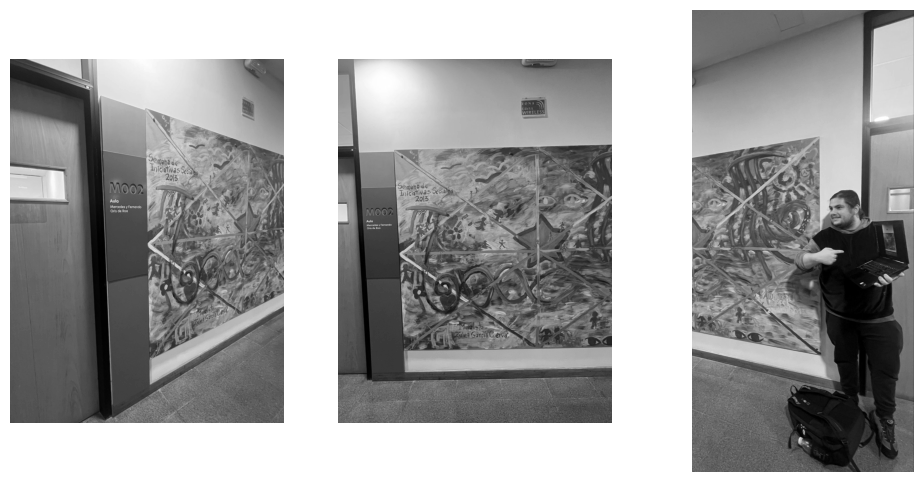

In [58]:
images = [cv2.imread(f'img/udesa_{i}.jpeg', cv2.IMREAD_GRAYSCALE) for i in range(3)]
show_images(images)

## Deteccion y Descripcion de Caracteristicas Visuales

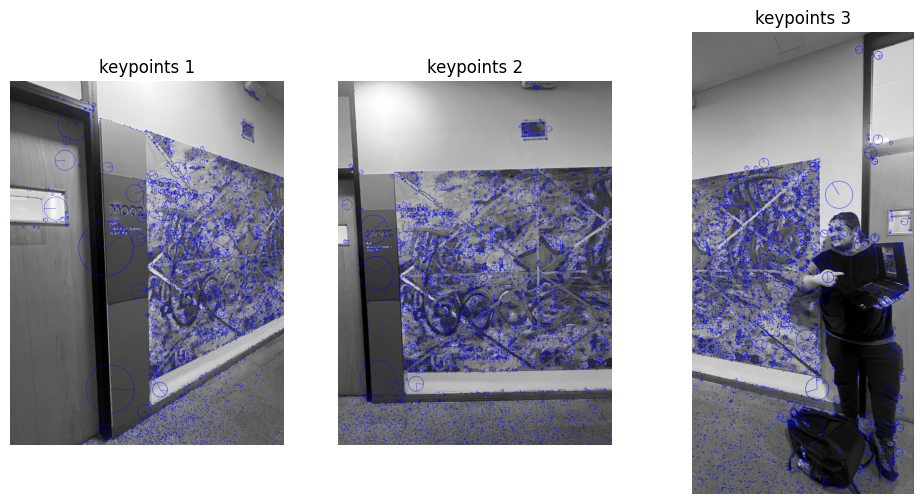

In [59]:
sift_algo = cv2.SIFT_create()
images_keypoints = []
images_descriptors = []

for i in range(len(images)):
    kp, des = sift_algo.detectAndCompute(images[i], None)
    images_keypoints.append(kp)
    images_descriptors.append(des)

images_with_kp = []
for i in range(len(images)):
    img_bgr = cv2.cvtColor(images[i], cv2.COLOR_GRAY2BGR)
    img_with_kp = cv2.drawKeypoints(
        img_bgr,
        images_keypoints[i],
        0, (255, 0, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    images_with_kp.append(img_with_kp)

show_images(images_with_kp, ["keypoints 1", "keypoints 2", "keypoints 3"])

In [ ]:
def adaptive_non_max_suppression(keypoints, descriptors, base_radius=10.0, max_kp=10000):
    if not keypoints:
        return [], None

    pts = np.array([kp.pt for kp in keypoints])
    responses = np.array([kp.response for kp in keypoints])
    sizes = np.array([kp.size for kp in keypoints])

    order = np.argsort(-responses)
    tree = cKDTree(pts)
    suppressed = np.zeros(len(keypoints), dtype=bool)
    keep = []

    for i in order:
        if suppressed[i]:
            continue

        keep.append(i)
        if len(keep) >= max_kp:
            break

        adaptive_radius = base_radius * (sizes[i] / np.mean(sizes))
        neighbors = tree.query_ball_point(pts[i], adaptive_radius)
        suppressed[neighbors] = True
        suppressed[i] = False 

    filtered_keypoints = [keypoints[i] for i in keep]
    filtered_descriptors = descriptors[keep] if descriptors is not None else None

    return filtered_keypoints, filtered_descriptors
    
for i in range(len(images_keypoints)):
    images_keypoints[i], images_descriptors[i] = adaptive_non_max_suppression(
        images_keypoints[i],
        images_descriptors[i],
        max_kp=10000
    )

## Asociacion de Caracteristicas

### Cross-check

Matches between image 0 and image 1: 356
Matches between image 1 and image 2: 337


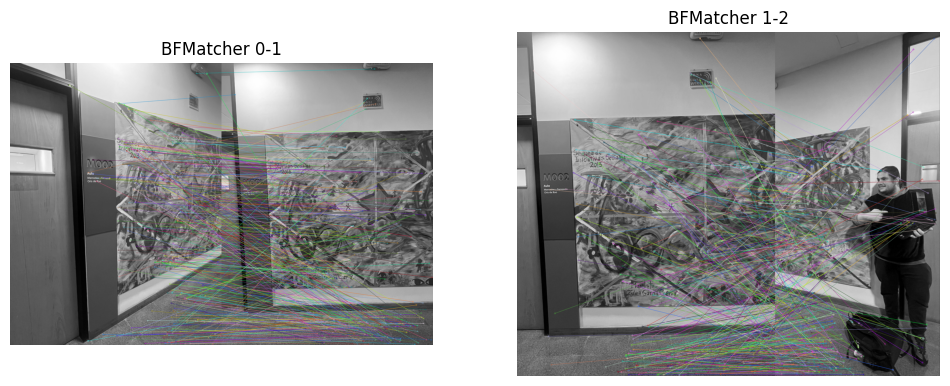

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

def bf_cross_check(desc1, desc2, matcher):
    desc1 = desc1.astype(np.float32)
    desc2 = desc2.astype(np.float32)
    matches = matcher.match(desc1, desc2)
    return sorted(matches, key=lambda x: x.distance)

matches01_cross = bf_cross_check(images_descriptors[0], images_descriptors[1], bf)
matched_img01_cross = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    matches01_cross, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

matches12_cross = bf_cross_check(images_descriptors[1], images_descriptors[2], bf)
matched_img12_cross = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    matches12_cross, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

show_images([matched_img01_cross, matched_img12_cross], ["BFMatcher 0-1", "BFMatcher 1-2"])
print(f"Matches between image 0 and image 1: {len(matches01_cross)}")
print(f"Matches between image 1 and image 2: {len(matches12_cross)}")

 ### Lowe´s Ratio

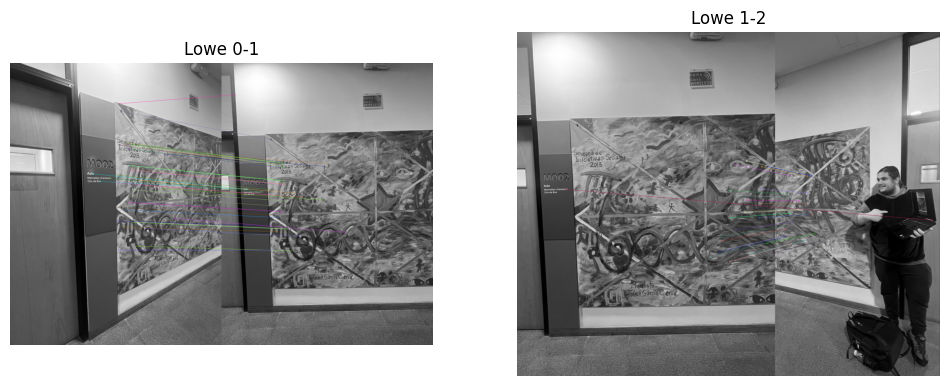

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L2)

def bf_lowe_test(desc1, desc2, ratio=0.6):
    desc1 = desc1.astype(np.float32)
    desc2 = desc2.astype(np.float32)
    knn_matches = bf.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in knn_matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    return good_matches

matches01_lowe = bf_lowe_test(images_descriptors[0], images_descriptors[1])
matched_img01_lowe = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    matches01_lowe, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

matches12_lowe = bf_lowe_test(images_descriptors[1], images_descriptors[2])
matched_img12_lowe = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    matches12_lowe, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

show_images([matched_img01_lowe, matched_img12_lowe], ["Lowe 0-1", "Lowe 1-2"])

### Cross-check vs Lowe´s Ratio

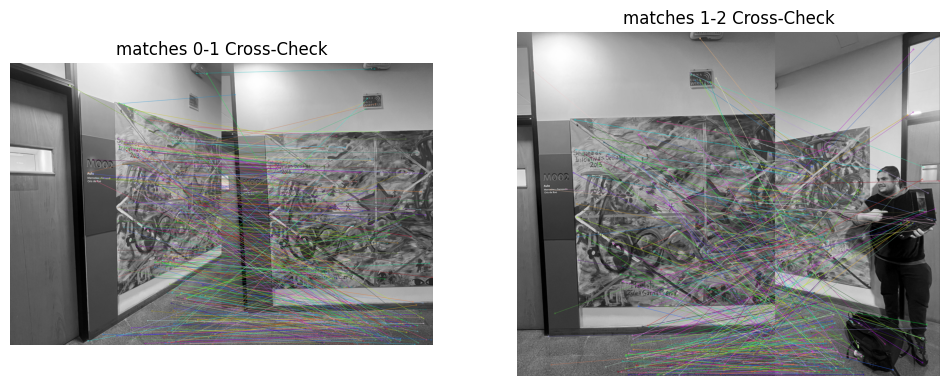

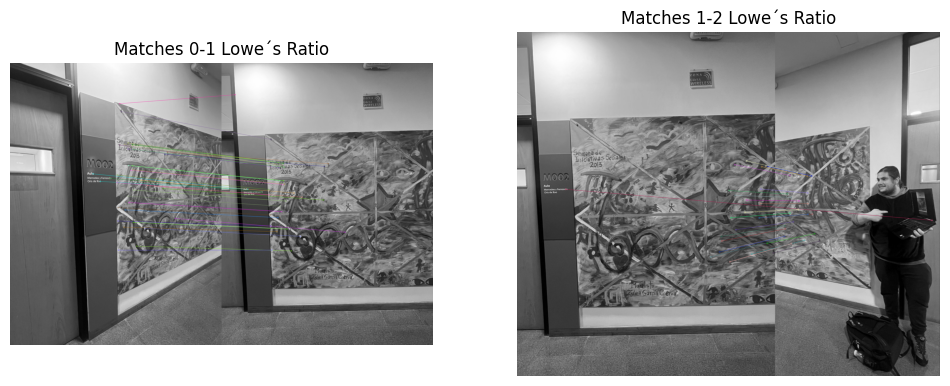

In [63]:
show_images([matched_img01_cross, matched_img12_cross], ["matches 0-1 Cross-Check", "matches 1-2 Cross-Check"])
show_images([matched_img01_lowe, matched_img12_lowe], ["Matches 0-1 Lowe´s Ratio", "Matches 1-2 Lowe´s Ratio"])

In [ ]:
def normalize_points(points):
    points = np.array(points)
    centroid = np.mean(points, axis=0)
    shifted = points - centroid
    dists = np.linalg.norm(shifted, axis=1)
    mean_dist = np.mean(dists)
    scale = np.sqrt(2) / mean_dist
    T = np.array([[scale, 0, -scale * centroid[0]],
                  [0, scale, -scale * centroid[1]],
                  [0,    0,                  1]])
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])
    normalized_points = (T @ points_hom.T).T
    return normalized_points, T

def dlt(ori, dst):
    ori = np.array(ori)
    dst = np.array(dst)
    norm_ori, T_ori = normalize_points(ori)
    norm_dst, T_dst = normalize_points(dst)
    A = []
    for i in range(4):
        x, y, _ = norm_ori[i]
        xp, yp, _ = norm_dst[i]
        A.append([-x, -y, -1,  0,  0,  0, x * xp, y * xp, xp])
        A.append([ 0,  0,  0, -x, -y, -1, x * yp, y * yp, yp])
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1]
    H_normalized = h.reshape(3, 3)
    H = np.linalg.inv(T_dst) @ H_normalized @ T_ori
    H /= H[2, 2]

    return H

def apply_homography(H, points):
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])
    transformed_points = points_homogeneous @ H.T
    transformed_points /= transformed_points[:, 2][:, np.newaxis]
    return transformed_points[:, :2]

def compute_precision(original_points, transformed_points):
    errors = np.linalg.norm(original_points - transformed_points, axis=1)
    return np.mean(errors)

p0 = [
    [2304, 1157],
    [2756, 1360],
    [2930, 1038],
    [2597, 1685],
]

p1 = [
    [1407, 1219],
    [1873, 1407],
    [2025, 1096],
    [1721, 1732],
    [2022, 1548]
]

p2 = [
    [466, 1381],
    [651, 1067],
    [311, 1714],
    [611, 1522]
]

p0_matched = np.array(p0)
p1_matched = np.array(p1[:-1])
H1 = dlt(p0_matched, p1_matched)

p1_matched_2 = np.array(p1[1:])
p2_matched = np.array(p2)
H2 = dlt(p1_matched_2, p2_matched)

p0_to_p1_transformed = apply_homography(H1, p0_matched)
p1_to_p2_transformed = apply_homography(H2, p1_matched_2)

precision_p0_p1 = compute_precision(p1_matched, p0_to_p1_transformed)
precision_p1_p2 = compute_precision(p2_matched, p1_to_p2_transformed)

precision_p0_p1, precision_p1_p2


(1.2758606932951651e-12, 1.24994451504292e-11)

## RANSAC

In [ ]:
def ransac_homography_from_matches(kp1: list, kp2: list, matches: list, max_iterations: int = 1000, threshold: float = 5.0):
    max_inliers = 0
    best_inliers = []
    best_H = None

    for _ in range(max_iterations):
        sample_matches = np.random.choice(matches, 4, replace=False)

        points1 = [kp1[m.queryIdx].pt for m in sample_matches]
        points2 = [kp2[m.trainIdx].pt for m in sample_matches]

        H = dlt(points1, points2)

        inliers = []
        for m in matches:
            pt1 = np.array([*kp1[m.queryIdx].pt, 1], dtype=np.float32)
            pt2 = np.array([*kp2[m.trainIdx].pt, 1], dtype=np.float32)

            projected_pt = H @ pt1
            projected_pt /= projected_pt[2]
            distance = np.linalg.norm(projected_pt[:2] - pt2[:2])

            if distance < threshold:
                inliers.append(m)

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_inliers = inliers
            best_H = H

    return best_H, best_inliers

ransac_01_H, ransac_01_inliers = ransac_homography_from_matches(
    images_keypoints[0], images_keypoints[1], matches01_lowe, max_iterations=1000, threshold=5.0
)
ransac_12_H, ransac_12_inliers = ransac_homography_from_matches(
    images_keypoints[1], images_keypoints[2], matches12_lowe, max_iterations=1000, threshold=5.0
)

print(f"RANSAC 0-1: {len(ransac_01_inliers)} inliers")
print(f"RANSAC 1-2: {len(ransac_12_inliers)} inliers")


/tmp/ipykernel_8212/2881701892.py:22: RuntimeWarning: divide by zero encountered in divide
  projected_pt /= projected_pt[2]  # Normalize homogeneous coordinates
/tmp/ipykernel_8212/2881701892.py:22: RuntimeWarning: invalid value encountered in divide
  projected_pt /= projected_pt[2]  # Normalize homogeneous coordinates


RANSAC 0-1: 36 inliers
RANSAC 1-2: 23 inliers


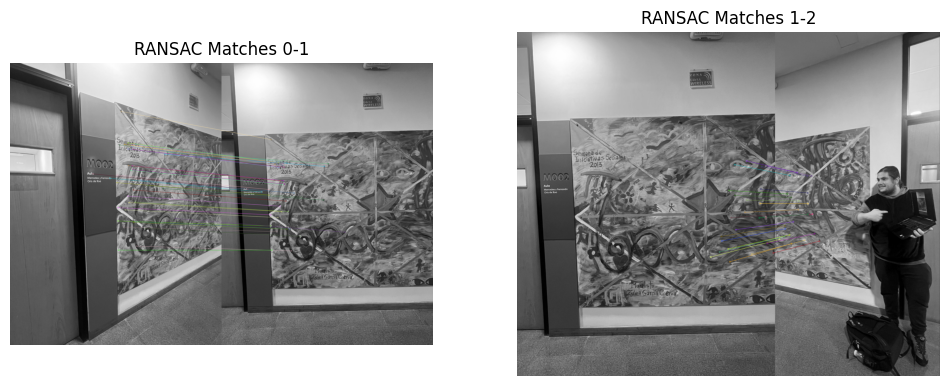

In [ ]:
inlier_matches_01 = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    ransac_01_inliers, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
inlier_matches_12 = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    ransac_12_inliers, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
show_images([inlier_matches_01, inlier_matches_12], ["RANSAC Matches 0-1", "RANSAC Matches 1-2"])

In [ ]:
pts_01_src = np.float32([images_keypoints[0][m.queryIdx].pt for m in ransac_01_inliers])
pts_01_dst = np.float32([images_keypoints[1][m.trainIdx].pt for m in ransac_01_inliers])

H_cv2_01, mask_01 = cv2.findHomography(pts_01_src, pts_01_dst)

pts_12_src = np.float32([images_keypoints[1][m.queryIdx].pt for m in ransac_12_inliers])
pts_12_dst = np.float32([images_keypoints[2][m.trainIdx].pt for m in ransac_12_inliers])

H_cv2_12, mask_12 = cv2.findHomography(pts_12_src, pts_12_dst)

print("Homografía 0 → 1 (OpenCV):\n", H_cv2_01)
print("Homografía 1 → 2 (OpenCV):\n", H_cv2_12)


Homografía 0 → 1 (OpenCV):
 [[ 4.97378254e-01  5.72049550e-03 -1.27158274e+02]
 [-3.89299878e-01  4.94129738e-01  4.00310228e+02]
 [-5.04182206e-04 -4.11974779e-05  1.00000000e+00]]
Homografía 1 → 2 (OpenCV):
 [[ 4.41706650e-01  3.37758106e-02 -4.16917035e+02]
 [-1.94278503e-01  5.40311068e-01  3.59668975e+02]
 [-2.61499127e-04  1.36429692e-05  1.00000000e+00]]


Bounds: -128 -318 1844 2200


True

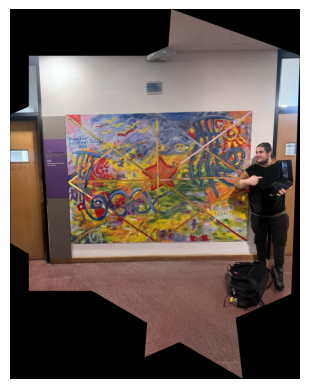

In [68]:
def cylindrical_warp(img, f):
    h, w = img.shape[:2]
    xs, ys = np.meshgrid(np.arange(w), np.arange(h))
    xs_c = xs - w / 2
    ys_c = ys - h / 2
    theta = np.arctan(xs_c / f)
    h_ = ys_c / np.sqrt(xs_c**2 + f**2)
    map_x = (f * theta + w / 2).astype(np.float32)
    map_y = (f * h_ + h / 2).astype(np.float32)
    cyl = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return cyl

def compute_panorama_bounds(images, H_matrices):
    all_corners = []
    for img, H in zip(images, H_matrices):
        h, w = img.shape[:2]
        corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners, H)
        all_corners.append(warped_corners)
    all_corners = np.vstack(all_corners)
    x_min = int(np.floor(all_corners[:, 0, 0].min()))
    y_min = int(np.floor(all_corners[:, 0, 1].min()))
    x_max = int(np.ceil(all_corners[:, 0, 0].max()))
    y_max = int(np.ceil(all_corners[:, 0, 1].max()))
    return x_min, y_min, x_max, y_max

H0 = H_cv2_01
H1 = np.eye(3)
H2 = np.linalg.inv(H_cv2_12)
H_matrices = [H0, H1, H2]

focal_length = 5000
images = [cv2.imread(f'img/udesa_{i}.jpeg') for i in range(3)]

images_cyl = [cylindrical_warp(img, focal_length) for img in images]

x_min, y_min, x_max, y_max = compute_panorama_bounds(images_cyl, H_matrices)
print("Bounds:", x_min, y_min, x_max, y_max)

translation = np.array([[1, 0, -x_min],
                        [0, 1, -y_min],
                        [0, 0, 1]])
pano_width = x_max - x_min
pano_height = y_max - y_min

warped_images = []
for idx, (img, H) in enumerate(zip(images_cyl, H_matrices)):
    warped = cv2.warpPerspective(img, translation @ H, (pano_width, pano_height))
    warped_images.append(warped)

accum = np.zeros((pano_height, pano_width, 3), dtype=np.float32)
weight_accum = np.zeros((pano_height, pano_width), dtype=np.float32)

for warped in warped_images:
    mask = np.any(warped > 0, axis=2).astype(np.uint8)
    mask_8u = (mask * 255).astype(np.uint8)
    dist = cv2.distanceTransform(mask_8u, cv2.DIST_L2, 3)
    weight = dist[..., np.newaxis]
    
    accum += warped.astype(np.float32) * weight
    weight_accum += dist

weight_accum_3c = np.repeat(weight_accum[..., np.newaxis], 3, axis=2)
panorama = accum / np.maximum(weight_accum_3c, 1e-6)
panorama = panorama.astype(np.uint8)

imshow(panorama)
cv2.imwrite("output.jpeg", panorama)
